# Lab 3: Bayes Classifier and Boosting

In [363]:
%matplotlib inline
import numpy as np
from scipy import misc
from imp import reload
from labfuns import *
import random

## Bayes classifier functions

In [774]:
# NOTE: you do not need to handle the W argument for this part!
# in: labels - N vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels, W=None):
    Npts = labels.shape[0]
    if W is None:
        W = np.ones((Npts,1))/Npts
    else:
        assert(W.shape[0] == Npts)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    W = (W * 1e5).astype(int)
    labels = np.hstack([np.repeat(labels[i], W[i]) for i in range(Npts)])
    prior = np.unique(labels, return_counts=True)[1]/len(labels)
    
    return prior

# NOTE: you do not need to handle the W argument for this part!
# in:      X - N x d matrix of N data points
#     labels - N vector of class labels
# out:    mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
def mlParams(X, labels, W=None):
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones((Npts,1))/float(Npts)

    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))

    for ci, c in enumerate(classes):
        idx = np.where(labels == c)
        wi = W.T[0][idx]
        for d in range(Ndims):
            xi = X.T[d][idx]
            mu[ci][d] = sum(wi*xi)/sum(wi)
            
    for ci, c in enumerate(classes):
        idx = np.where(labels == c)
        wi = W.T[0][idx]
        for d in range(Ndims):
            xi = X.T[d][idx]
            sigma[ci][d][d] = np.sum(wi*(xi - mu[ci][d])**2)/sum(wi)

    return mu, sigma

# in:      X - N x d matrix of M data points
#      prior - C x 1 matrix of class priors
#         mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
# out:     h - N vector of class predictions for test points
def classifyBayes(X, prior, mu, sigma):
    Npts = X.shape[0]
    Nclasses,Ndims = np.shape(mu)
    logProb = np.zeros((Nclasses, Npts))

    for pt in range(Npts):
        for ci in range(Nclasses):
            logProb[ci][pt] -= 0.5*np.log(np.linalg.det(sigma[ci]))
            logProb[ci][pt] -= 0.5*(X[pt]-mu[ci])*(1.0/np.diag(sigma[ci]))@(X[pt]-mu[ci]).T
            logProb[ci][pt] += np.log(prior[ci])
    
    # one possible way of finding max a-posteriori once
    # you have computed the log posterior
    h = np.argmax(logProb,axis=0)
    return h

In [775]:
class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

## Maximum Likelihood estimates

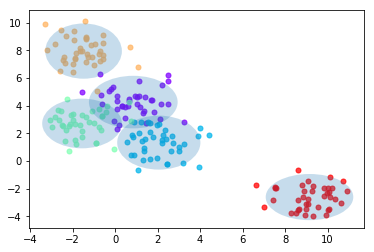

In [776]:
%matplotlib inline

X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels)
plotGaussian(X,labels,mu,sigma)

## Testing the performance of classifiers

In [777]:
testClassifier(BayesClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 84.4
Trial: 10 Accuracy 95.6
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 86.7
Trial: 40 Accuracy 88.9
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 86.7
Trial: 70 Accuracy 91.1
Trial: 80 Accuracy 86.7
Trial: 90 Accuracy 91.1
Final mean classification accuracy  89 with standard deviation 4.16


### The accuracy is reasonably high

In [778]:
testClassifier(BayesClassifier(), dataset='vowel', split=0.7)

Trial: 0 Accuracy 61
Trial: 10 Accuracy 66.2
Trial: 20 Accuracy 74
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 64.3
Trial: 60 Accuracy 66.9
Trial: 70 Accuracy 63.6
Trial: 80 Accuracy 62.3
Trial: 90 Accuracy 70.8
Final mean classification accuracy  64.7 with standard deviation 4.03


### The accuracy is quite low

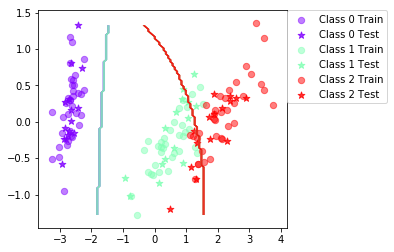

In [779]:
%matplotlib inline
plotBoundary(BayesClassifier(), dataset='iris',split=0.7)

*(1) When can a feature independence assumption be reasonable and when not?*

**Feature independence is reasonable to assume when there is low correlation between the two features**

*(2) How does the decision boundary look for the Iris dataset? How could one improve the classification results for this scenario by changing classifier or, alternatively, manipulating the data?*

**The decisions boundaries look quite accurate except between class 2 and 1 in a specific region. Classification can be improved by using different classifier (decision tree could improve score) OR by focusing learning in ambiguous boundary region (high error should have higher density).**

## Boosting functions to implement

In [767]:
X,y,pcadim = fetchDataset()
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7,1)
pca = decomposition.PCA(n_components=2)
a=pca.fit(xTr)
xTr = pca.transform(xTr)
xTe = pca.transform(xTe)
Npts,Ndims = np.shape(xTr)
wCur = np.ones((Npts,1))/float(Npts)

X = xTr
Npts,Ndims = np.shape(X)
alphas = []

# do classification for each point
vote = BayesClassifier().trainClassifier(xTr, yTr, wCur).classify(xTr)
lamb = np.vectorize(lambda x, y: 1 if x == y else 0)
error = (wCur.T[0]*(1-lamb(vote, labels))).sum()
alpha = 0.5*(np.log(1-error) - np.log(error))
#newCur = np.exp(-alpha) * wCur.reshape(105,) * (vote == labels).astype(int)
#newCur += np.exp(alpha) * wCur.reshape(105,) * (vote != labels).astype(int)
newCur = wCur
wCur = (newCur * 1e5).astype(int)

classes = np.unique(yTr)
Nclasses = np.size(classes)
new_y = np.hstack([np.repeat(yTr[i], wCur[i]) for i in range(Npts)])
np.unique(new_y, return_counts=True)[1]/len(new_y)

array([ 0.33333333,  0.33333333,  0.33333333])

In [780]:
# in: base_classifier - a classifier of the type that we will boost, e.g. BayesClassifier
#                   X - N x d matrix of N data points
#              labels - N vector of class labels
#                   T - number of boosting iterations
# out:    classifiers - (maximum) length T Python list of trained classifiers
#              alphas - (maximum) length T Python list of vote weights
def trainBoost(base_classifier, X, labels, T=10):
    # these will come in handy later on
    Npts,Ndims = np.shape(X)

    classifiers = [] # append new classifiers to this list
    alphas = [] # append the vote weight of the classifiers to this list

    # The weights for the first iteration
    wCur = np.ones((Npts,1))/float(Npts)

    for i_iter in range(0, T):
        # a new classifier can be trained like this, given the current weights
        classifiers.append(base_classifier.trainClassifier(X, labels, wCur))
        
        # do classification for each point
        vote = classifiers[-1].classify(X)
        lamb = np.vectorize(lambda x, y: 1 if x == y else 0)
        error = (wCur.T[0]*(1-lamb(vote, labels))).sum()
        alpha = 0.5*(np.log(1-error) - np.log(error))
        newCur = np.exp(-alpha) * wCur.reshape(105,) * (vote == labels).astype(int)
        newCur += np.exp(alpha) * wCur.reshape(105,) * (vote != labels).astype(int)
        wCur = newCur
        
        alphas.append(alpha)
        
    return classifiers, alphas

# in:       X - N x d matrix of N data points
# classifiers - (maximum) length T Python list of trained classifiers as above
#      alphas - (maximum) length T Python list of vote weights
#    Nclasses - the number of different classes
# out:  yPred - N vector of class predictions for test points
def classifyBoost(X, classifiers, alphas, Nclasses):
    Npts = X.shape[0]
    Ncomps = len(classifiers)

    # if we only have one classifier, we may just classify directly
    if Ncomps == 1:
        return classifiers[0].classify(X)
    else:
        votes = np.zeros((Npts,Nclasses))

        votes.append([alphas[t]*lamb(classifiers[t].classify(X), 1) for t in range(0, T)])
        votes.append([alphas[t]*lamb(classifiers[t].classify(X), 2) for t in range(0, T)])

        # ==========================

        # one way to compute yPred after accumulating the votes
        return np.argmax(votes,axis=1)

The implemented functions can now be summarized another classifer, the `BoostClassifier` class. This class enables boosting different types of classifiers by initializing it with the `base_classifier` argument. No need to add anything here.

In [781]:
# NOTE: no need to touch this
class BoostClassifier(object):
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        rtn = BoostClassifier(self.base_classifier, self.T)
        rtn.nbr_classes = np.size(np.unique(labels))
        rtn.classifiers, rtn.alphas = trainBoost(self.base_classifier, X, labels, self.T)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBoost(X, self.classifiers, self.alphas, self.nbr_classes)

## Run some experiments

Call the `testClassifier` and `plotBoundary` functions for this part.

In [782]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)

IndexError: invalid index to scalar variable.

In [ ]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='vowel',split=0.7)

In [ ]:
%matplotlib inline
plotBoundary(BoostClassifier(BayesClassifier()), dataset='iris',split=0.7)

Now repeat the steps with a decision tree classifier.

In [ ]:
testClassifier(DecisionTreeClassifier(), dataset='iris', split=0.7)

In [ ]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

In [ ]:
testClassifier(DecisionTreeClassifier(), dataset='vowel',split=0.7)

In [ ]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.7)

In [ ]:
%matplotlib inline
plotBoundary(DecisionTreeClassifier(), dataset='iris',split=0.7)

In [ ]:
%matplotlib inline
plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

## Bonus: Visualize faces classified using boosted decision trees

Note that this part of the assignment is completely voluntary! First, let's check how a boosted decision tree classifier performs on the olivetti data. Note that we need to reduce the dimension a bit using PCA, as the original dimension of the image vectors is `64 x 64 = 4096` elements.

In [ ]:
testClassifier(BayesClassifier(), dataset='olivetti',split=0.7, dim=20)

In [ ]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='olivetti',split=0.7, dim=20)

You should get an accuracy around 70%. If you wish, you can compare this with using pure decision trees or a boosted bayes classifier. Not too bad, now let's try and classify a face as belonging to one of 40 persons!

In [ ]:
%matplotlib inline
X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7) # split into training and testing
pca = decomposition.PCA(n_components=20) # use PCA to reduce the dimension to 20
pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(DecisionTreeClassifier(), T=10).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])